# The Vehicle Routing Problem (VRP)

The Vehicle Routing Problem (VRP) is an combinatorial optimization problem of finding a set of routes for a fleet of vehicles that minimizes travel time. The Vehicle Routing Problem can be thought of as multiple Travelling Salesman Problems (TSP) combined together.

INPUT
- List of Locations that needs to be visited
- Number of Vehicles
- Location of the Depot. Which is used as the starting adn ending point for all the vehicles.

SCORING:

:::{abdominition} Representation

:::

```{figure} ./../img/2024-04-25-12-49-18.png.png
---
align: center
---
Example VRP with three vehicles
Source: https://commons.wikimedia.org/wiki/File:Figure_illustrating_the_vehicle_routing_problem.png
Image by PierreSelim. Released to public domain
```


- Determine the longest route of all the vehicles -> The larger the route the worse the score


:::{abdominition} Resources
- [Google OR Tools - Vehicle Routing Problem Explainaition](https://developers.google.com/optimization/routing/vrp)

:::




## 1. Build a Basic VRP Solver

Starter Code: You may use the following implementation of tsp to ge you started.

It should pass the following:

When called like:

```py
# create a problem instance:
vrp = VehicleRoutingProblem("bayg29", 3, 12)

# generate random solution and evaluate it:
randomSolution = random.sample(range(len(vrp)), len(vrp))
print("random solution = ", randomSolution)
print("route breakdown = ", vrp.getRoutes(randomSolution))
print("max distance = ", vrp.getMaxDistance(randomSolution))

# plot the solution:
plot = vrp.plotData(randomSolution)
plot.show()

```

It should output:

```py
>python vrp.py
https://raw.githubusercontent.com/mastqe/tsplib/master/bayg29.tsp
length = 29, locations = [array([1150., 1760.], dtype=float32), array([ 630., 1660.], dtype=float32), array([  40., 2090.], dtype=float32), array([ 750., 1100.], dtype=float32), array([ 750., 2030.], dtype=float32), array([1030., 2070.], dtype=float32), array([1650.,  650.], dtype=float32), array([1490., 1630.], dtype=float32), array([ 790., 2260.], dtype=float32), array([ 710., 1310.], dtype=float32), array([840., 550.], dtype=float32), array([1170., 2300.], dtype=float32), array([ 970., 1340.], dtype=float32), array([510., 700.], dtype=float32), array([750., 900.], dtype=float32), array([1280., 1200.], dtype=float32), array([230., 590.], dtype=float32), array([460., 860.], dtype=float32), array([1040.,  950.], dtype=float32), array([ 590., 1390.], dtype=float32), array([ 830., 1770.], dtype=float32), array([490., 500.], dtype=float32), array([1840., 1240.], dtype=float32), array([1260., 1500.], dtype=float32), array([1280.,  790.], dtype=float32), array([ 490., 2130.], dtype=float32), array([1460., 1420.], dtype=float32), array([1260., 1910.], dtype=float32), array([ 360., 1980.], dtype=float32)]
0, 1: location1 = [1150. 1760.], location2 = [ 630. 1660.] => distance = 529.528076171875
0, 2: location1 = [1150. 1760.], location2 = [  40. 2090.] => distance = 1158.0155029296875
0, 3: location1 = [1150. 1760.], location2 = [ 750. 1100.] => distance = 771.7512817382812
...
0, 4: location1 = [1150. 1760.], location2 = [ 750. 2030.] => distance = 482.5971374511719
0, 5: location1 = [1150. 1760.], location2 = [1030. 2070.] => distance = 332.4154052734375
0, 6: location1 = [1150. 1760.], location2 = [1650.  650.] => distance = 1217.415283203125
random solution =  [13, 25, 17, 16, 14, 23, 28, 7, 12, 0, 1, 10, 29, 26, 2, 27, 19, 11, 21, 8, 24, 22, 15, 4, 5, 6, 30, 20, 9, 3, 18]
route breakdown =  [[13, 25, 17, 16, 14, 23, 28, 7, 0, 1, 10], [26, 2, 27, 19, 11, 21, 8, 24, 22, 15, 4, 5, 6], [20, 9, 3, 18]]
```

```{figure} ./../img/2024-04-25-14-32-40.png
---
align: center
---

Should print something like this.
```

### Base Code

In [4]:
import csv
import pickle
import os
import codecs

import numpy as np

from urllib.request import urlopen

import matplotlib.pyplot as plt



class TravelingSalesmanProblem:
    """This class encapsulates the Traveling Salesman Problem.
    City coordinates are read from an online file and distance matrix is calculated.
    The data is serialized to disk.
    The total distance can be calculated for a path represented by a list of city indices.
    A plot can be created for a path represented by a list of city indices.

    :param name: The name of the corresponding TSPLIB problem, e.g. 'burma14' or 'bayg29'.
    """

    def __init__(self, name):
        """
        Creates an instance of a TSP

        :param name: name of the TSP problem
        """

        # initialize instance variables:
        self.name = name
        self.locations = []
        self.distances = []
        self.tspSize = 0

        # initialize the data:
        self.__initData()

    def __len__(self):
        """
        returns the length of the underlying TSP
        :return: the length of the underlying TSP (number of cities)
        """
        return self.tspSize

    def __initData(self):
        """Reads the serialized data, and if not available - calls __create_data() to prepare it
        """

        # attempt to read serialized data:
        try:
            self.locations = pickle.load(open(os.path.join("tsp-data", self.name + "-loc.pickle"), "rb"))
            self.distances = pickle.load(open(os.path.join("tsp-data", self.name + "-dist.pickle"), "rb"))
        except (OSError, IOError):
            pass

        # serailized data not found - create the data from scratch:
        if not self.locations or not self.distances:
            self.__createData()

        # set the problem 'size':
        self.tspSize = len(self.locations)

    def __createData(self):
        """Reads the desired TSP file from the Internet, extracts the city coordinates, calculates the distances
        between every two cities and uses them to populate a distance matrix (two-dimensional array).
        It then serializes the city locations and the calculated distances to disk using the pickle utility.
        """
        self.locations = []

        # print("http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/" + self.name + ".tsp")
        
        # Use the following instead: https://raw.githubusercontent.com/mastqe/tsplib/master/a280.tsp
        URL = "https://raw.githubusercontent.com/mastqe/tsplib/master/"
        print(URL + self.name + ".tsp")
        # open whitespace-delimited file from url and read lines from it:
        with urlopen(URL + self.name + ".tsp") as f:
            reader = csv.reader(codecs.iterdecode(f, 'utf-8'), delimiter=" ", skipinitialspace=True)

            # skip lines until one of these lines is found:
            for row in reader:
                if row[0] in ('DISPLAY_DATA_SECTION', 'NODE_COORD_SECTION'):
                    break

            # read data lines until 'EOF' found:
            for row in reader:
                if row[0] != 'EOF':
                    # remove index at beginning of line:
                    del row[0]

                    # convert x,y coordinates to ndarray:
                    self.locations.append(np.asarray(row, dtype=np.float32))
                else:
                    break

            # set the problem 'size':
            self.tspSize = len(self.locations)

            # print data:
            print("length = {}, locations = {}".format(self.tspSize, self.locations))

            # initialize distance matrix by filling it with 0's:
            self.distances = [[0] * self.tspSize for _ in range(self.tspSize)]

            # populate the distance matrix with calculated distances:
            for i in range(self.tspSize):
                for j in range(i + 1, self.tspSize):
                    # calculate euclidean distance between two ndarrays:
                    distance = np.linalg.norm(self.locations[j] - self.locations[i])
                    self.distances[i][j] = distance
                    self.distances[j][i] = distance
                    print("{}, {}: location1 = {}, location2 = {} => distance = {}".format(i, j, self.locations[i], self.locations[j], distance))

            # serialize locations and distances:
            if not os.path.exists("tsp-data"):
                os.makedirs("tsp-data")
            pickle.dump(self.locations, open(os.path.join("tsp-data", self.name + "-loc.pickle"), "wb"))
            pickle.dump(self.distances, open(os.path.join("tsp-data", self.name + "-dist.pickle"), "wb"))

    def getTotalDistance(self, indices):
        """Calculates the total distance of the path described by the given indices of the cities

        :param indices: A list of ordered city indices describing the given path.
        :return: total distance of the path described by the given indices
        """
        # distance between th elast and first city:
        distance = self.distances[indices[-1]][indices[0]]

        # add the distance between each pair of consequtive cities:
        for i in range(len(indices) - 1):
            distance += self.distances[indices[i]][indices[i + 1]]

        return distance

    def plotData(self, indices, label=None):
        """plots the path described by the given indices of the cities

        :param indices: A list of ordered city indices describing the given path.
        :return: the resulting plot
        """

        # plot the dots representing the cities:
        plt.scatter(*zip(*self.locations), marker='.', color='red')

        # create a list of the corresponding city locations:
        locs = [self.locations[i] for i in indices]
        locs.append(locs[0])

        # plot a line between each pair of consequtive cities:
        plt.plot(*zip(*locs), linestyle='-', color='blue')
        if label:
            plt.title(label)

        return plt
    
# Starter Code
    
    
class VehicleRoutingProblem:

    def __init__(self, tspName, numOfVehicles, depotIndex):
        """
        Creates an instance of a VRP
        :param tspName: name of the underlying TSP
        :param numOfVehicles: number of vehicles used
        :param depotIndex: the index of the TSP city that will be used as the depot location
        """
        self.tsp = TravelingSalesmanProblem(tspName)
        self.numOfVehicles = numOfVehicles
        self.depotIndex = depotIndex

    def __len__(self):
        """
        returns the number of indices used to internally represent the VRP
        :return: the number of indices used to internally represent the VRP
        """
        return len(self.tsp) + self.numOfVehicles - 1

    def getRoutes(self, indices):
        """
        breaks the list of given indices into separate routes,
        by detecting the 'separator' indices
        :param indices: list of indices, including 'separator' indices
        :return: a list of routes, each route being a list of location indices from the tsp problem
        """

        # initialize lists:
        routes = []
        route = []

        # loop over all indices in the list:
        for i in indices:

            # skip depot index:
            if i == self.depotIndex:
                continue

            # index is part of the current route:
            if not self.isSeparatorIndex(i):
                route.append(i)

            # separator index - route is complete:
            else:
                routes.append(route)
                route = []  # reset route

        # append the last route:
        if route or self.isSeparatorIndex(i):
            routes.append(route)

        return routes

    def isSeparatorIndex(self, index):
        """
        Finds if curent index is a separator index
        :param index: denotes the index of the location
        :return: True if the given index is a separator
        """
        # check if the index is larger than the number of the participating locations:
        return index >= len(self) - (self.numOfVehicles - 1)

    def getRouteDistance(self, indices):
        """Calculates total the distance of the path that starts at the depo location and goes through
        the cities described by the given indices

        :param indices: a list of ordered city indices describing the given path.
        :return: total distance of the path described by the given indices
        """
        if not indices:
            return 0

        # find the distance between the depo location and the city:
        distance = self.tsp.distances[self.depotIndex][indices[0]]

        # add the distance between the last city and the depot location:
        distance += self.tsp.distances[indices[-1]][self.depotIndex]

        # add the distances between the cities along the route:
        for i in range(len(indices) - 1):
            distance += self.tsp.distances[indices[i]][indices[i + 1]]
        return distance

    def getTotalDistance(self, indices):
        """Calculates the combined distance of the various paths described by the given indices

        :param indices: a list of ordered city indices and separator indices describing one or more paths.
        :return: combined distance of the various paths described by the given indices
        """
        totalDistance = 0
        for route in self.getRoutes(indices):
            routeDistance = self.getRouteDistance(route)
            #print("- route distance = ", routeDistance)
            totalDistance += routeDistance
        return totalDistance

    def getMaxDistance(self, indices)-> float:
        """Calculates the max distance among the distances of the various paths described by the given indices

        :param indices: a list of ordered city indices and separator indices describing one or more paths.
        :return: max distance among the distances of the various paths described by the given indices
        """
        maxDistance = 0
        for route in self.getRoutes(indices):
            # TODO get the distance of the current route:
            
            # TODO update the max distance if the current route distance is larger
            pass
        
        return maxDistance

    def getAvgDistance(self, indices) -> float:
        """Calculates the average distance among the distances of the various paths described by the given indices
        Does not consider empty paths

        :param indices: a list of ordered city indices and separator indices describing one or more paths.
        :return: max distance among the distances of the various paths described by the given indices
        """
        # TODO Get routes, for each route if the route is not empty. Calculate the distance and add it to the total distance
        
        # TODO Return the average distance
        pass

    def plotData(self, indices) -> plt: 
        """breaks the list of indices into separate routes and plot each route in a different color

        :param indices: A list of ordered indices describing the combined routes
        :return: the resulting plot
        """
        
        # TODO plot the dots representing the cities:
        
        # TODO mark the depot with a large 'x'
        
        # TODO break the indices into separate routes and plot each route in a different color
        
        pass
    

### Solution

Check the solution.

In [5]:



class VehicleRoutingProblem:

    def __init__(self, tspName, numOfVehicles, depotIndex):
        """
        Creates an instance of a VRP
        :param tspName: name of the underlying TSP
        :param numOfVehicles: number of vehicles used
        :param depotIndex: the index of the TSP city that will be used as the depot location
        """
        self.tsp = TravelingSalesmanProblem(tspName)
        self.numOfVehicles = numOfVehicles
        self.depotIndex = depotIndex

    def __len__(self):
        """
        returns the number of indices used to internally represent the VRP
        :return: the number of indices used to internally represent the VRP
        """
        return len(self.tsp) + self.numOfVehicles - 1

    def getRoutes(self, indices):
        """
        breaks the list of given indices into separate routes,
        by detecting the 'separator' indices
        :param indices: list of indices, including 'separator' indices
        :return: a list of routes, each route being a list of location indices from the tsp problem
        """

        # initialize lists:
        routes = []
        route = []

        # loop over all indices in the list:
        for i in indices:

            # skip depot index:
            if i == self.depotIndex:
                continue

            # index is part of the current route:
            if not self.isSeparatorIndex(i):
                route.append(i)

            # separator index - route is complete:
            else:
                routes.append(route)
                route = []  # reset route

        # append the last route:
        if route or self.isSeparatorIndex(i):
            routes.append(route)

        return routes

    def isSeparatorIndex(self, index):
        """
        Finds if curent index is a separator index
        :param index: denotes the index of the location
        :return: True if the given index is a separator
        """
        # check if the index is larger than the number of the participating locations:
        return index >= len(self) - (self.numOfVehicles - 1)

    def getRouteDistance(self, indices):
        """Calculates total the distance of the path that starts at the depo location and goes through
        the cities described by the given indices

        :param indices: a list of ordered city indices describing the given path.
        :return: total distance of the path described by the given indices
        """
        if not indices:
            return 0

        # find the distance between the depo location and the city:
        distance = self.tsp.distances[self.depotIndex][indices[0]]

        # add the distance between the last city and the depot location:
        distance += self.tsp.distances[indices[-1]][self.depotIndex]

        # add the distances between the cities along the route:
        for i in range(len(indices) - 1):
            distance += self.tsp.distances[indices[i]][indices[i + 1]]
        return distance

    def getTotalDistance(self, indices):
        """Calculates the combined distance of the various paths described by the given indices

        :param indices: a list of ordered city indices and separator indices describing one or more paths.
        :return: combined distance of the various paths described by the given indices
        """
        totalDistance = 0
        for route in self.getRoutes(indices):
            routeDistance = self.getRouteDistance(route)
            #print("- route distance = ", routeDistance)
            totalDistance += routeDistance
        return totalDistance

    def getMaxDistance(self, indices):
        """Calculates the max distance among the distances of the various paths described by the given indices

        :param indices: a list of ordered city indices and separator indices describing one or more paths.
        :return: max distance among the distances of the various paths described by the given indices
        """
        maxDistance = 0
        for route in self.getRoutes(indices):
            routeDistance = self.getRouteDistance(route)
            #print("- route distance = ", routeDistance)
            maxDistance = max(routeDistance, maxDistance)
        return maxDistance

    def getAvgDistance(self, indices):
        """Calculates the average distance among the distances of the various paths described by the given indices
        Does not consider empty paths

        :param indices: a list of ordered city indices and separator indices describing one or more paths.
        :return: max distance among the distances of the various paths described by the given indices
        """

        routes = self.getRoutes(indices)
        totalDistance = 0
        counter = 0
        for route in routes:
            if route:  # consider only routes that are not empty
                routeDistance = self.getRouteDistance(route)
                # print("- route distance = ", routeDistance)
                totalDistance += routeDistance
                counter += 1
        return totalDistance/counter

    def plotData(self, indices):
        """breaks the list of indices into separate routes and plot each route in a different color

        :param indices: A list of ordered indices describing the combined routes
        :return: the resulting plot
        """

        # plot th ecities of the underlying TSP:
        plt.scatter(*zip(*self.tsp.locations), marker='.', color='red')

        # mark the depot location with a large 'X':
        d = self.tsp.locations[self.depotIndex]
        plt.plot(d[0], d[1], marker='x', markersize=10, color='green')

        # break the indices to separate routes and plot each route in a different color:
        routes = self.getRoutes(indices)
        color = iter(plt.cm.rainbow(np.linspace(0, 1, self.numOfVehicles)))
        for route in routes:
            route = [self.depotIndex] + route + [self.depotIndex]
            stops = [self.tsp.locations[i] for i in route]
            plt.plot(*zip(*stops), linestyle='-', color=next(color))

        return plt



random solution =  [25, 29, 11, 16, 19, 10, 12, 22, 0, 4, 21, 6, 7, 27, 18, 8, 2, 20, 5, 13, 28, 15, 24, 30, 14, 23, 1, 26, 17, 9, 3]
route breakdown =  [[25], [11, 16, 19, 10, 22, 0, 4, 21, 6, 7, 27, 18, 8, 2, 20, 5, 13, 28, 15, 24], [14, 23, 1, 26, 17, 9, 3]]
max distance =  20626.178


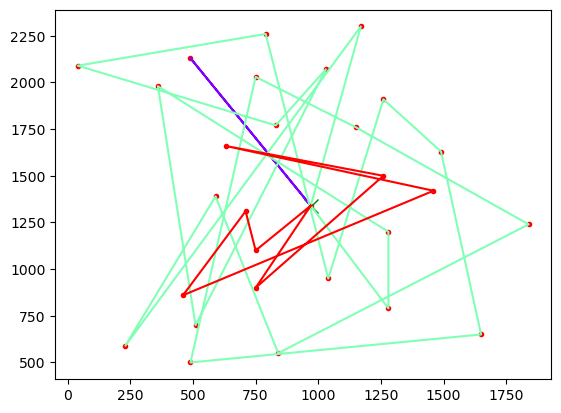

In [8]:
import random

# create a problem instance:
vrp = VehicleRoutingProblem("bayg29", 3, 12)

# generate random solution and evaluate it:
randomSolution = random.sample(range(len(vrp)), len(vrp))
print("random solution = ", randomSolution)
print("route breakdown = ", vrp.getRoutes(randomSolution))
print("max distance = ", vrp.getMaxDistance(randomSolution))

# plot the solution:
plot = vrp.plotData(randomSolution)
plot.show()


## Implemente a Genetic Algorithm for VRP

Using DEAP framework implement a Genetic Algorithm for VRP.


**set the random seed:**
- RANDOM_SEED = 42
- random.seed(RANDOM_SEED)

**create the desired vehicle routing problem using a traveling salesman problem instance:**
- TSP_NAME = "bayg29"
- NUM_OF_VEHICLES = 3
- DEPOT_LOCATION = 12

**Genetic Algorithm constants:**
- POPULATION_SIZE = 500
- P_CROSSOVER = 0.9  # probability for crossover
- P_MUTATION = 0.2   # probability for mutating an individual
- MAX_GENERATIONS = 1000
- HALL_OF_FAME_SIZE = 30

**Toolbox Setttings**

- Fitness Min with base weight of -1.[^base-fitness]
- Register Individual [^individual] using array of integers. That uses `fitnessMin` as the fitness function.
- Register an operator `randomOrder` that generates a random shuffle of indices used to internally represent the VRP
- Register an operator `evaluate` that calculates the total distance of the VRP solution
- Individual Creator operator named `individualCreator` that: [^inititerate]
  - Takes as container the individual class
  -  uses `randomOrder` to generate the individual
-  Population Creator operator named `populationCreator` that: [^initrepeat]
  - Takes as container the list class
  - Uses `individualCreator` to generate the population

[^base-fitness]: base.Fitness - http://deap.gel.ulaval.ca/doc/dev/tutorials/basic/part1.html#fitness
[^individual]: individual -  http://deap.gel.ulaval.ca/doc/dev/tutorials/basic/part1.html#individual
[^inititerate]: init Iterate -  [deap.tools.initIterate(container, generator)](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.initIterate)  
Call the function container with an iterable as its only argument. The iterable must be returned by the method or the object generator. ![](./../img/2024-04-25-15-05-38.png) 
[^initrepeat]: init repeat - https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.initRepeat - Call the function func n times and return the results in a container type container  ![](./../img/2024-04-25-15-04-47.png) 

**toolbox Genetic Algorithm Settings**

- use vrp.getMaxDistance(individual) to calculate the fitness of the individual [^evaluate]
- Use Tournament selection of tournament size 2. [^selTorunament]
- `mutate` using strategy `mutShuffleIndexes` that shuffles the indexes of the individual ussing indenpendt probability for each attribute to be exchaged as the inverse of the number of attributes.
- `mate` using strategy: cxUniformPartiallyMatched[^xcuniformpartiallymatched] that uses indenpendt probability for each attribute to be exchaged as the inverse of the number of attributes * 2.
- Which is similar to a combination of the Uniform [^uniformmutation] and Partially Matched [^partiallymatched] crossover operators.
- 

[^evaluate]: evaluate - http://deap.gel.ulaval.ca/doc/dev/tutorials/basic/part2.html#evaluating-the-individuals; tournsize – The number of individuals participating in each tournament.

[^selTorunament]: [deap.tools.selTournament(individuals, k, tournsize, fit_attr='fitness')](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.selTournament) ![](./../img/2024-04-25-16-04-45.png)

[^xcuniformpartiallymatched]: [cxUniformPartiallyMatched](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxTwoPoint) - Executes a uniform partially matched [^partiallymatched] crossover (UPMX) on the input individuals. The two individuals are modified in place. This crossover expects sequence individuals of indices, the result for any other type of individuals is unpredictable. ![](./../img/2024-04-25-16-22-58.png)

[^uniformmutation]: In uniform mutation we select a random gene from our chromosome, let’s say xi and assign a uniform random value to it.[![](./../img/2024-04-25-16-16-00.png) ](https://www.researchgate.net/figure/Illustration-of-uniform-crossover-and-uniform-mutation-operators-Individuals-are_fig3_311940166)

[^partiallymatched]: Partially matched seem to take parts of A and B and then swap them. ![](./../img/2024-04-25-16-18-45.png)




